# Introduction
This notebook demonstrate a machine learning model project prototyping from [Grab AI Challenge in Traffic Management](https://www.aiforsea.com/traffic-management) as a starting kit.

## Objective

> Economies in Southeast Asia are turning to AI to solve traffic congestion, which hinders mobility and economic growth. The first step in the push towards alleviating traffic congestion is to understand travel demand and travel patterns within the city.
> 
> Can we accurately forecast travel demand based on historical Grab bookings to predict areas and times with high travel demand?

In [1]:
!pip install pendulum

In [2]:
!pip install fbprophet

In [3]:
!pip install tensorflow

In [4]:
!pip install keras

In [5]:
!pip install geohash

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geohash
from matplotlib import pyplot as plt
from math import sin, cos, sqrt, atan2, radians
import pendulum
from scipy.interpolate import interpn
from sklearn.preprocessing import LabelBinarizer , LabelEncoder, OneHotEncoder, MinMaxScaler
import os
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error

import utils
import gc # garbage collector
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [8]:
import tensorflow as tf

In [9]:
import plotly
plotly.__version__
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Data Exploratory and wrangling
First step in machine learning is always about understanding the data

In [10]:
df = pd.read_csv("Traffic Management Training.csv")

In [11]:
# check for null values
df[df.isnull().any(axis=1)]

,geohash6,day,timestamp,demand


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   geohash6   object 
 1   day        int64  
 2   timestamp  object 
 3   demand     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


In [13]:
df.describe()

,day,demand
count,4.206321e+06,4.206321e+06
mean,3.145299e+01,1.050907e-01
std,1.768278e+01,1.592655e-01
min,1.000000e+00,3.092217e-09
25%,1.600000e+01,1.867379e-02
50%,3.200000e+01,5.043463e-02
75%,4.700000e+01,1.208644e-01
max,6.100000e+01,1.000000e+00


In [14]:
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


### Decoding geohash6
We will do a decoding into latitude and longitude back this encoding to find out more information about the the data location.
> Geohash is a public domain geocoding system invented by Gustavo Niemeyer[1], which encodes a geographic location into a short string of letters and digits. It is a hierarchical spatial data structure which subdivides space into buckets of grid shape, which is one of the many applications of what is known as a Z-order curve, and generally space-filling curves (source: wikipedia).

More information about the geohash can be found in wikipedia: [wikipedia](https://en.wikipedia.org/wiki/Geohash): 

> So geohash6 means that it has 6 characters with the precision of ±0.61km (610m). I suspect landmark or point of interest is already compressed into this single encoding value.

In [15]:
# get the unique hashes
geohashes_df = df.groupby('geohash6', as_index=False)\
.agg({'day':'count'})\
.rename(columns={'day':'count'})\
.sort_values(by='count', ascending=False)

In [16]:
print("Total encoded hash",len(geohashes_df))

Total encoded hash 1329


In [17]:
geohashes_df.sort_values(by='count', ascending=False).head()

,geohash6,count
232,qp03wz,5846
275,qp03yb,5846
261,qp03xw,5846
215,qp03wf,5846
210,qp03w9,5845


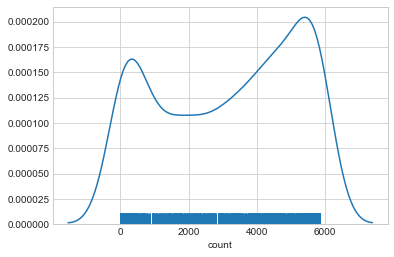

In [18]:
# find out the distribution of the hash
ax = sns.distplot(geohashes_df['count'], rug=True, hist=False)

In [19]:
import Geohash

In [20]:
%%time
# decode geohash into lat and long
geohashes_df['lat'] = None
geohashes_df['lat_err'] = None
geohashes_df['long'] = None
geohashes_df['long_err'] = None
for i in range(len(geohashes_df)):
    geo_decoded = Geohash.decode_exactly(geohashes_df.loc[i,'geohash6'])
    geohashes_df.loc[i,'lat'] = geo_decoded[0]
    geohashes_df.loc[i,'long'] = geo_decoded[1]
    geohashes_df.loc[i,'lat_err'] = geo_decoded[2]
    geohashes_df.loc[i,'long_err'] = geo_decoded[3]

Wall time: 1.83 s


In [21]:
# top 10 geo
geohashes_df.head(10)

,geohash6,count,lat,lat_err,long,long_err
232,qp03wz,5846,-5.32013,0.00274658,90.6537,0.00549316
261,qp03xw,5846,-5.32562,0.00274658,90.6866,0.00549316
215,qp03wf,5846,-5.3476,0.00274658,90.6537,0.00549316
275,qp03yb,5846,-5.31464,0.00274658,90.6537,0.00549316
507,qp092m,5845,-5.37506,0.00274658,90.7196,0.00549316
683,qp0987,5845,-5.3421,0.00274658,90.7196,0.00549316
322,qp03zv,5845,-5.28717,0.00274658,90.6976,0.00549316
262,qp03xx,5845,-5.32013,0.00274658,90.6866,0.00549316
822,qp09e5,5845,-5.3421,0.00274658,90.8405,0.00549316
210,qp03w9,5845,-5.35309,0.00274658,90.6427,0.00549316


In [22]:
# merge into original df
df = df.merge(geohashes_df.drop(columns=['count']), on='geohash6', how='inner')

In [23]:
# convert lat and long into float type
df['lat'] = df['lat'].astype('float64')
df['long'] = df['long'].astype('float64')
df['lat_err'] = df['lat_err'].astype('float64')
df['long_err'] = df['long_err'].astype('float64')

### Timestamp and day
The timestamp is not a linux timestamp but rather a `hour:minute` form. Another thing we don't have is the context of  month and year. But we'll make an attempt to deduce. Knowing which month and year could help us in forming seasonality or holiday that potentially affecting the prediction

In [24]:
# extract hour and minute from timestamp column
df[['h','m']] = df['timestamp'].str.split(':',expand=True)
df['h'] = df['h'].astype('int64')
df['m'] = df['m'].astype('int64')

In [25]:
# extract day of week (DoW) from day
# since we have no idea about which month is this data were taken so can't
# be sure the DoW starts on which day
# but it's good enought we dont need to dig deeper I supposed
# but in test set clearly this thing needs to be mapped out correcly
df['dow'] = df['day'] % 7

In [26]:
df.head(1)

,geohash6,day,timestamp,demand,lat,lat_err,long,long_err,h,m,dow
0,qp03wc,18,20:0,0.020072,-5.353088,0.002747,90.653687,0.005493,20,0,4


In [27]:
# outlier from day
zscore = lambda x: (x - x.mean()) / x.std()
df['zscore_day'] = np.abs(df.groupby('day')['demand'].transform(zscore))
print("number of suspected outliers from day", len(df[df['zscore_day'] > 3]))

number of suspected outliers from day 112915


In [28]:
# outlier from timestamp
df['zscore_timestamp'] = np.abs(df.groupby('timestamp')['demand'].transform(zscore))
print("number of suspected outliers from timestamp", len(df[df['zscore_timestamp'] > 3]))

number of suspected outliers from timestamp 115887


In [29]:
_ = df[(df['zscore_day'] <= 3) & (df['zscore_timestamp'] <= 3)].groupby(['dow','h'], as_index=False)\
.agg({'demand':'mean'})\
.sort_values(by=['dow','h'])

In [30]:
_.head()

,dow,h,demand
0,0,0,0.083209
1,0,1,0.087051
2,0,2,0.084850
3,0,3,0.089713
4,0,4,0.095321


In [31]:
# To change the colourscale, uncomment all this code and replace "RdBu_r with one of the swatch colours printed out."
# Reverse colour scale with a _r at the end of the colour name
# import plotly.express as px

# fig = px.colors.diverging.swatches().update_layout(margin_b=10)
# fig.show()

In [32]:
import random

x=[str(i) for i in range(24)]
y=[str(i) for i in range(7)]
b = [[i + random.random() for i in range(len(x))] for ii in range(len(y))]

hovertext = list()
for yi, yy in enumerate(y):
    hovertext.append(list())
    for xi, xx in enumerate(x):
        hovertext[-1].append('Hour of Day: {}<br />Day of Week: {}'.format(xx, yy, b[yi][xi]))

data = [
    go.Heatmap(

        z=_['demand'].values.reshape((7,24)),
        x=[str(i) for i in range(24)],
        y=[str(i) for i in range(7)],
        colorscale='Spectral_r',
        hoverinfo='text',
        text=hovertext)

]

layout = go.Layout(
    title='Average Demand in Day of Week x 24 hours',
    xaxis=dict(
        title='Hours',
    ),
    yaxis=dict(
        title='Day of Week',
    ),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)


### Heatmap analysis
* We have no context which month the day 0 is
* But from heatmap I would speculate that the 0 is Monday 
* Since we can observe the stripe on 6th DoW noticably deviating from the rest, this could indicate Sunday
* Looking at the "First month" vs "second month" plot, I suspect the dataset were derived from Malaysia and for October and November 2018.

In [33]:
# let's find out since 2018 which month has monday for their first day
start = pendulum.datetime(2018, 1, 1)
end = pendulum.datetime(2019, 5, 22)

period = pendulum.period(start, end)

for dt in period.range('days'):
    if dt.day_of_week == pendulum.MONDAY and dt.day == 1:
        print(dt.to_date_string(), "number of days:", dt.end_of('month').day-dt.start_of('month').day+1)

2018-01-01 number of days: 31
2018-10-01 number of days: 31
2019-04-01 number of days: 30


In [34]:
_ = df.groupby('day', as_index=False).agg({'demand':'mean'})

In [35]:
x = [i for i in range(31)]
trace1 = go.Scatter(
    x = x,
    y = _['demand'][0:31],
    mode = 'lines+markers',
    name = 'First Month'
)
trace2 = go.Scatter(
    x = x,
    y = _['demand'][31:61],
    mode = 'lines+markers',
    name = 'Second Month'
)

data = [trace1, trace2]
iplot(data)

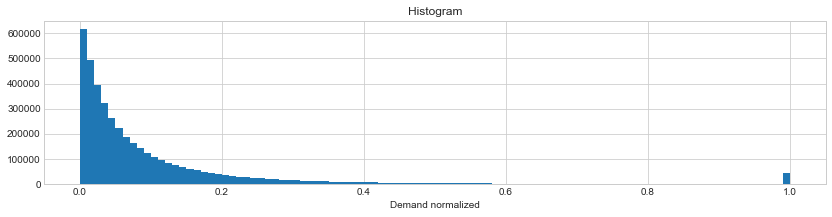

In [36]:
# demand distribution
df['demand'].hist(bins=100, figsize=(14,3))
plt.xlabel('Demand normalized')
plt.title('Histogram');

In [37]:
df.corr()

,day,demand,lat,lat_err,long,long_err,h,m,dow,zscore_day,zscore_timestamp
day,1.000000,0.023643,-0.003743,NaN,0.010102,NaN,-0.000031,0.000121,0.039480,0.004439,0.013755
demand,0.023643,1.000000,-0.021700,NaN,-0.032438,NaN,-0.085078,-0.002702,-0.022668,0.866154,0.832214
lat,-0.003743,-0.021700,1.000000,NaN,0.139660,NaN,0.023533,-0.000274,-0.000554,0.012840,0.019077
lat_err,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
long,0.010102,-0.032438,0.139660,NaN,1.000000,NaN,-0.080137,-0.000405,-0.009581,-0.019259,-0.025569
long_err,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h,-0.000031,-0.085078,0.023533,NaN,-0.080137,NaN,1.000000,0.002456,0.004612,-0.017734,-0.018887
m,0.000121,-0.002702,-0.000274,NaN,-0.000405,NaN,0.002456,1.000000,0.000157,-0.001938,-0.000046
dow,0.039480,-0.022668,-0.000554,NaN,-0.009581,NaN,0.004612,0.000157,1.000000,-0.008805,-0.014114
zscore_day,0.004439,0.866154,0.012840,NaN,-0.019259,NaN,-0.017734,-0.001938,-0.008805,1.000000,0.929904


### Analysis of the Geo data

In [38]:
def calc_dist(lat1, long1, lat2, long2):
    # calculate distance between two coordinate using Haversine formula
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [39]:
# minimum and maximum latitude
lat_min, lat_max = df['lat'].min(), df['lat'].max()
# minimum and maximum longitude
long_min, long_max = df['long'].min(), df['long'].max()

In [40]:
print("Min coordinate", (lat_min, long_min))
print("Max coordinate", (lat_max, long_max))

Min coordinate (-5.48492431640625, 90.5877685546875)
Max coordinate (-5.23773193359375, 90.9722900390625)


In [41]:
lat_A = lat_max
long_A = long_min
lat_B = lat_min
long_B = long_max
dA = calc_dist(lat_min, long_min, lat_A, long_A)
dB = calc_dist(lat_min, long_min, lat_B, long_B)
diameter = calc_dist(lat_min, long_min, lat_max, long_max)

### Calculate the bounding area
* The square area (KM) of the GPS bounding box is $ 1,170 km^2 $ . So I imagine the size close to Penang

In [42]:
print("Circle Area",np.pi * (diameter/2)**2)
print("Square area", dA*dB)

Circle Area 2017.9282884108472
Square area 1170.5911178111999


## Plot into Map
Here we want to understand if we can use external data augmentation from the geo location. But turns out the location were masked into ocean. Unless grab is providing on demand hailing to Atlantist, I'm afraid we can't do much use the geo data for augmentation such as landmarks (point of interest).

In [43]:
# https://www.openstreetmap.org/#map=4/-6.61/109.16
# The bounding box in openstreetmap: left, bottom, right, top (min long, min lat, max long, max lat)
bbox = (89.00, 119.31,-9.15, 10.17) # we'll plot long on x-axis
sea_map = plt.imread("http://madet.my/images/map_sea_trim.png")

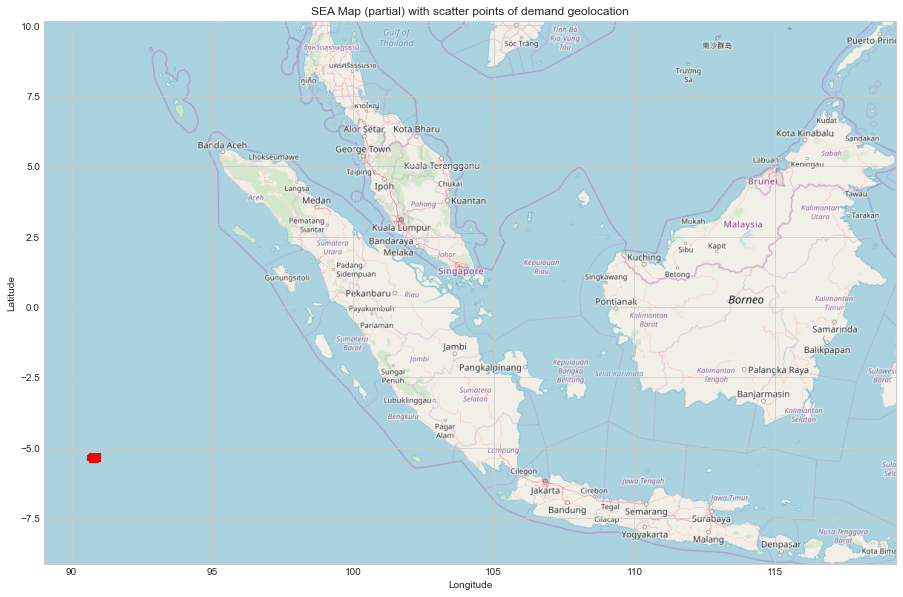

In [44]:
alpha=0.3
s=1
fig, ax = plt.subplots(1, 1, figsize=(16,10))
ax.scatter(df['long'],df['lat'], zorder=1, alpha=alpha, c='r', s=s)
ax.set_xlim((bbox[0], bbox[1]))
ax.set_ylim((bbox[2], bbox[3]))
ax.set_title('SEA Map (partial) with scatter points of demand geolocation')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.imshow(sea_map, zorder=0, extent=bbox)
plt.show()

Wall time: 2.12 s


Text(0.5, 1.0, 'Density of demand by location')

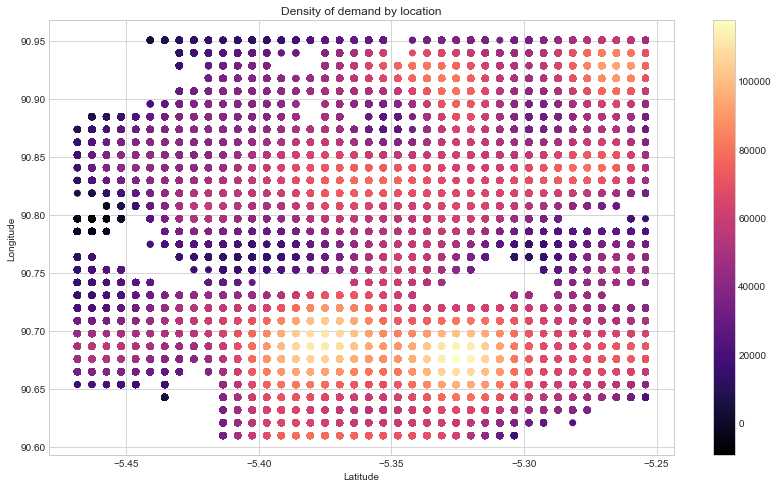

In [45]:
%%time
x = df['lat'].values
y = df['long'].values
plt.figure(figsize=(14,8))
data , x_e, y_e = np.histogram2d( x, y)
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
            data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x, y, c=z, cmap='magma')
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Density of demand by location');

# Baseline Models
* This is a supervised learning problem where we can throw to the model the features as well as actual values to be learned. 
* Since we have multiple features to be used as forecasting step, it's fall under multivariate forecasting
* We'll tackle using 2 simple approach here: 
  * fbprohet multivariate through regressor
  * Neural network
  
  
* Here what I meant by baseline model is that there is no improvement after first time running the model. In the actual machine learning project one would usually have this similar approach and incrementally fine tune the model to produce better result such as finding best hyperparameter, adding more features, remove outliers, and etc
* From my experience working with machine learning project major challenge usualy is overfit and imbalance class issues. If we look at the the geohash observation some only got few example so it could potentially overfit and produce far incorrect prediction in production environment. Another thing to observe is outliers, one scenario is sudden spike in certain areas due to a random events. We probably want to exclude this if such spike is not repeatable in seasonality pattern.
  

In [46]:
# label encode the geohash6
# though the best way is probably onehot encode, but we'll leave it to next iteration
labelencoder = LabelEncoder()
df['geo_encoded'] = labelencoder.fit_transform(df['geohash6'])

In [47]:
# @TODO encode the geo to onehot or binary
# lb = LabelBinarizer(sparse_output=False)
# lb.fit(df['geo_encoded'])
# we'll transform geohash6 into onehot
# lb.transform([212]).shape

In [48]:
# select only column we're interested in
df = df[['day','h', 'm', 'dow','geo_encoded','demand']]

## Fbprophet
fbprophet is the easiest tool for forecasting where you can model your solution quickly and sometime it's already good enough.

**UPDATE:** I did not include the 5 steps forward forecasting here, but we can easily use manual predict method and incrementally predict T+1 until T+5

In [49]:
import fbprophet
Prophet = fbprophet.Prophet

In [50]:
df_copy = df.copy()
df_copy['year'] = 2018
df_copy['day_'] = df_copy['day'].apply(lambda x : x if x <= 31 else x-31 )
df_copy['month'] = df_copy['day'].apply(lambda x : 10 if x <= 31 else 11 )
df_copy['s'] = 0
df_copy['ds'] = pd.to_datetime(dict(year=df_copy.year, month=df_copy.month, day=df_copy.day_, hour=df_copy.h, minute=df_copy.m))

In [51]:
# remove columns that are not be used in the model
df_copy.drop(columns=['day','h','m', 's', 'dow', 'year', 'day_', 's', 'month'], inplace=True)

In [52]:
# fbprophet expect the y column
df_copy.rename(columns={'demand':'y'}, inplace=True)

In [53]:
df_copy.head()

,geo_encoded,y,ds
0,212,0.020072,2018-10-18 20:00:00
1,212,0.512506,2018-10-19 05:30:00
2,212,0.668930,2018-10-20 12:15:00
3,212,0.047361,2018-11-28 21:00:00
4,212,1.000000,2018-11-29 10:45:00


In [54]:
#df_copy.groupby('geo_encoded').agg({'ds':'count'}).sort_values(by='ds', ascending=False).head()

In [55]:
#df_copy = df_copy.sample(frac=0.1, random_state=1)
# we'll take only one of the geohash area as taking entire dataset is extremely expensive
# It would take 1h 28min 24s for training
# so to save time I'll pick first 5 top areas
df_copy = df_copy[df_copy['geo_encoded'].isin([232,261,215,275,507])]

In [56]:
#sort by datetime
df_copy = df_copy.sort_values(by=['ds'])

In [57]:
split_n = int(0.8*len(df_copy))
train = df_copy.iloc[:split_n,:]
test = df_copy.iloc[split_n:,:]

In [58]:
# mcmc_samples=300, changepoint_prior_scale=0.01 (enable this to get uncertainty bound)
m = Prophet(seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=True)

In [59]:
%%time
m.add_regressor('geo_encoded', mode='multiplicative')
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Wall time: 32.1 s


In [60]:
%%time
#future = m.make_future_dataframe(periods=5, freq='min')
future = train[['ds','geo_encoded']]
forecast = m.predict(future)
rmse = np.sqrt(mean_squared_error(train['y'], forecast['yhat']))
print(rmse)

0.23170379193884005
Wall time: 14.2 s


In [61]:
%%time
#future = m.make_future_dataframe(periods=5, freq='min')
future = test[['ds','geo_encoded']]
forecast = m.predict(future)
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
print(rmse)

0.24578643047424134
Wall time: 6.09 s


In [62]:
future = df_copy[['ds','geo_encoded']]
forecast = m.predict(future)

In [63]:
forecast['y'] = df_copy['y'].values
forecast['yhat_lower'] =  np.clip(forecast.yhat_lower, 0, 1)
forecast['yhat_upper'] =  np.clip(forecast.yhat_upper, 0, 1)

ConversionError: Failed to convert value(s) to axis units: '2018-11-18 19:30:00'

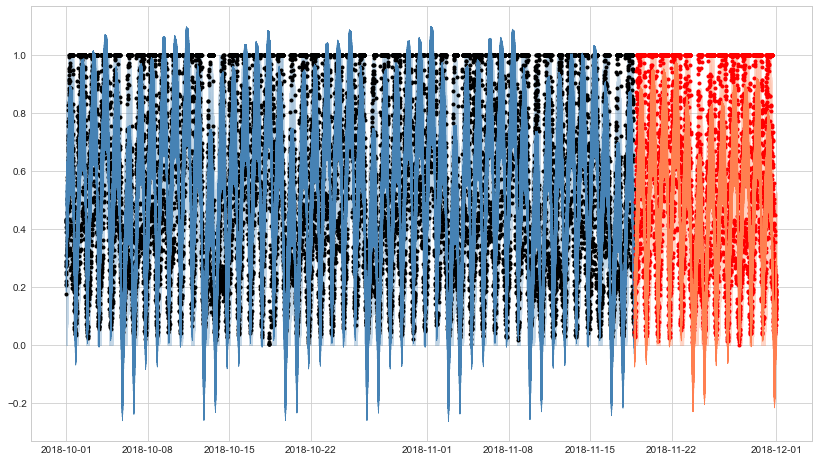

In [65]:
f, ax = plt.subplots(figsize=(14, 8))
first = forecast.iloc[:split_n,:]
ax.plot(first.ds, first.y, 'ko', markersize=3)
ax.plot(first.ds, first.yhat, color='steelblue', lw=0.5)
ax.fill_between(first.ds, first.yhat_lower, first.yhat_upper, color='steelblue', alpha=0.3)

second = forecast.iloc[split_n:,:]
ax.plot(second.ds, second.y, 'ro', markersize=3)
ax.plot(second.ds, second.yhat, color='coral', lw=0.5)
ax.fill_between(second.ds, second.yhat_lower, second.yhat_upper, color='coral', alpha=0.3)
ax.axvline(str(second.iloc[0]['ds']), color='0.8', alpha=0.9)
ax.grid(ls=':', lw=0.5)

In [66]:
# clean up 
del df_copy
del forecast
del future
gc.collect()

16763

# Neural Network (LSTM)

We'll try to build a Encoder-Decoder LSTM model for multi-step forecasting with multivariate input data using methods explained in [machinelearningmastery.com](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)

The final average RMSE is significantly lower than fbprohet. Thought I didn't have time to verify the result. I'll leave it to later time.


In [67]:
# We'll prototype using 100k sample since executing full 4 millions dataset will slow down our step
# once we have good model we can gradually increase the size and observe the accuracy.
df_sample = df.sample(100000, random_state=1)

In [68]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1825303 to 2212866
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   day          100000 non-null  int64  
 1   h            100000 non-null  int64  
 2   m            100000 non-null  int64  
 3   dow          100000 non-null  int64  
 4   geo_encoded  100000 non-null  int32  
 5   demand       100000 non-null  float64
dtypes: float64(1), int32(1), int64(4)
memory usage: 5.0 MB


In [69]:
df_sample = df_sample.sort_values(by=['day','h','m'])

In [70]:
df_sample.head()

,day,h,m,dow,geo_encoded,demand
865399,1,0,0,1,671,0.057435
2009061,1,0,0,1,1225,0.003797
3928723,1,0,0,1,227,0.145888
219839,1,0,0,1,208,0.003659
1799902,1,0,0,1,1144,0.027069


In [71]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
df_sample[['day','h','m','dow','geo_encoded']] = scaler.fit_transform(df_sample[['day','h','m','dow','geo_encoded']])

In [72]:
df_sample.shift(-1-i).values.shape

(100000, 6)

In [73]:
# frame as supervised learning
# we're asked to make prediction T+1 to T+4 
# I choose T-1 to T-16 for 4 hour lagging for our prediction
X = []
for i in range(16):
    X.append(df_sample.shift(-1-i).fillna(-1).values)
X=np.array(X)

In [74]:
X.shape

(16, 100000, 6)

In [75]:
X=X.reshape(X.shape[1],X.shape[0],X.shape[2])

In [76]:
# split into train and test
n_train = int(0.8*len(X))
X_train = X[:n_train,:,:]
X_test = X[n_train:,:,:]

In [77]:
X_train.shape, X_test.shape

((80000, 16, 6), (20000, 16, 6))

In [78]:
y = df_sample['demand'].values
y_train = y[:n_train]
y_test = y[n_train:]

In [79]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 30)            4440      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 30)            7320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 19,111
Trainable params: 19,111
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [81]:
model.fit(X_train, y_train, epochs=2, batch_size=128)

Epoch 1/2
625/625 [==============================] - 11s 17ms/step - loss: 0.0241
Epoch 2/2
625/625 [==============================] - 11s 17ms/step - loss: 0.0240


In [82]:
predicted_value= model.predict(X_test)

In [83]:
mean_squared_error(y_test,predicted_value)

0.02972114894414242